In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import itertools

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input, Conv2D, MaxPooling2D
from keras.optimizers import Adam, Adadelta
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.np_utils import to_categorical

In [3]:
train_dir = 'data\\train\\'
test_dir = 'data\\test\\'

In [4]:
SPECIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen',
              'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse',
              'Small-flowered Cranesbill', 'Sugar beet']
for species in SPECIES:
    print('{} -> {} images'.format(species,len(os.listdir(os.path.join(train_dir , species)))))

Black-grass -> 263 images
Charlock -> 390 images
Cleavers -> 287 images
Common Chickweed -> 611 images
Common wheat -> 221 images
Fat Hen -> 475 images
Loose Silky-bent -> 654 images
Maize -> 221 images
Scentless Mayweed -> 516 images
Shepherds Purse -> 231 images
Small-flowered Cranesbill -> 496 images
Sugar beet -> 385 images


In [5]:
train = []
for species_num ,species in enumerate(SPECIES):
    for file in os.listdir(os.path.join(train_dir ,species)):
        train.append(['data\\train\\{}\\{}'.format(species ,file) ,species_num ,species])

train = pd.DataFrame(train , columns = ['file' ,'species_num' ,'species'])
print('Training Data:',train.shape)


Training Data: (4750, 3)


In [6]:
#Image Pre-processing
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp


In [7]:
%%time
x_train = []
for i in range(len(train)):
    img = cv2.imread(train['file'][i])
    img = cv2.resize(img , dsize = (256 , 256))
    img_stack = segment_plant(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor(img_stack ,cv2.COLOR_RGB2GRAY)
    img_stack = np.reshape(img_stack ,(256,256,1))
    x_train.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))
x_train = np.array(x_train)
print(x_train.shape)

(4750, 256, 256, 4)
Wall time: 52.9 s


In [8]:
print(img.shape)
print(img_stack.shape)

(256, 256, 3)
(256, 256, 1)


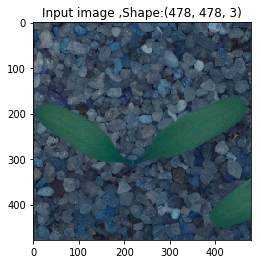

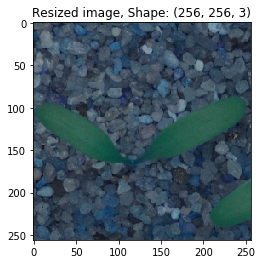

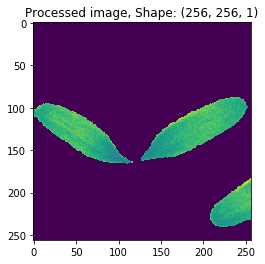

In [9]:
# Input image
Input_image = cv2.imread(train['file'][len(train) - 1])

plt.imshow(Input_image)
plt.title('Input image ,Shape:' + str(Input_image.shape))
plt.show()

# Resized image
plt.imshow(img)
plt.title('Resized image, Shape: '+str(img.shape))
plt.show()

# Processed image to Stack
plt.imshow(np.reshape(img_stack,(256,256)))
plt.title('Processed image, Shape: '+str(img_stack.shape))
plt.show()

In [10]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
from keras.utils.vis_utils import plot_model
input_shape = x_train[1].shape
print('Input Shape is :', input_shape)
def fire_incept(x, fire=16, intercept=64):
    x = Conv2D(fire, (5,5), strides=(2,2))(x)
    x = LeakyReLU(alpha=0.15)(x)
    
    left = Conv2D(intercept, (3,3), padding='same')(x)
    left = LeakyReLU(alpha=0.15)(left)
    
    right = Conv2D(intercept, (5,5), padding='same')(x)
    right = LeakyReLU(alpha=0.15)(right)
    
    x = concatenate([left, right], axis=3)
    return x

def fire_squeeze(x, fire=16, intercept=64):
    x = Conv2D(fire, (1,1))(x)
    x = LeakyReLU(alpha=0.15)(x)
    
    left = Conv2D(intercept, (1,1))(x)
    left = LeakyReLU(alpha=0.15)(left)
    
    right = Conv2D(intercept, (3,3), padding='same')(x)
    right = LeakyReLU(alpha=0.15)(right)
    
    x = concatenate([left, right], axis=3)
    return x

image_input=Input(shape=input_shape)

x = fire_incept((image_input), fire=16, intercept=16)

x = fire_incept(x, fire=32, intercept=32)
x = fire_squeeze(x, fire=32, intercept=32)

x = fire_incept(x, fire=64, intercept=64)
x = fire_squeeze(x, fire=64, intercept=64)

x = fire_incept(x, fire=64, intercept=64)
x = fire_squeeze(x, fire=64, intercept=64)

x = Conv2D(64, (3,3))(x)
x = LeakyReLU(alpha=0.1)(x)

x = Flatten()(x)

x = Dense(512)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.1)(x)

out = Dense(len(SPECIES), activation='softmax')(x)

model_new = Model(image_input, out)
model_new.summary()
plot_model(model_new, to_file="model.png",show_shapes=True)

Input Shape is : (256, 256, 4)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 4)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 126, 126, 16) 1616        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 126, 126, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 126, 126, 16) 2320        leaky_re_lu_1[0][0]              
______________________________________________________________________________

One-hot Encoding

In [11]:
labels = train['species_num']
labels = to_categorical(labels, num_classes = len(SPECIES))
x_train, x_val, y_train, y_val = train_test_split(x_train, labels, test_size = 0.1, random_state=10)
input_shape = x_train[1].shape
print('Input Shape is :', input_shape)

Input Shape is : (256, 256, 4)


In [14]:
model_new.compile(optimizer = Adam(lr=.00025) , loss = 'categorical_crossentropy', metrics=['accuracy'])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, 
                                            factor=0.5, min_lr=0.00001)
datagen = ImageDataGenerator(rotation_range=40, zoom_range = 0.2, width_shift_range=0.2, height_shift_range=0.2,
                             horizontal_flip=True, vertical_flip=True)
datagen.fit(x_train)
# model_new.load_weights('model_weights_2.h5f')
batch_size = 32
epochs = 30
history = model_new.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size), epochs = epochs,
                                  validation_data = (x_val,y_val), verbose = 1, 
                                  steps_per_epoch=x_train.shape[0] // batch_size, 
                                  callbacks=[learning_rate_reduction])
model_new.save_weights('model_weights_2.h5f', overwrite=True)

Epoch 1/30
133/133 [==============================] - 120s 901ms/step - loss: 0.2838 - acc: 0.8990 - val_loss: 0.2900 - val_acc: 0.9011
Epoch 2/30
133/133 [==============================] - 111s 837ms/step - loss: 0.2957 - acc: 0.8903 - val_loss: 0.2419 - val_acc: 0.9074
Epoch 3/30
133/133 [==============================] - 109s 822ms/step - loss: 0.2668 - acc: 0.9026 - val_loss: 0.2667 - val_acc: 0.9074
Epoch 4/30
133/133 [==============================] - 110s 825ms/step - loss: 0.2807 - acc: 0.9011 - val_loss: 0.2841 - val_acc: 0.8947
Epoch 5/30
133/133 [==============================] - 117s 877ms/step - loss: 0.2739 - acc: 0.8997 - val_loss: 0.2435 - val_acc: 0.9137
Epoch 6/30
133/133 [==============================] - 113s 850ms/step - loss: 0.2869 - acc: 0.8986 - val_loss: 0.2317 - val_acc: 0.9158
Epoch 7/30
133/133 [==============================] - 119s 892ms/step - loss: 0.2815 - acc: 0.9011 - val_loss: 0.2710 - val_acc: 0.9116
Epoch 8/30
133/133 [============================

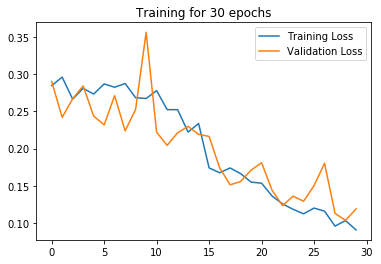

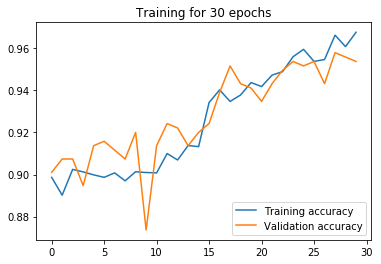

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

Predictions

In [17]:
%%time

test = []
for file in os.listdir(os.path.join(test_dir)):
    test.append(['data\\test\\{}'.format(file)])
test = pd.DataFrame(test, columns=['file'])
print(test.head(5))


x_test = []

for i in range(len(test)):
    img = cv2.imread(test['file'][i])
    img = cv2.resize(img,dsize=(256,256))
    img_stack = segment_plant(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(256,256,1))
    x_test.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))

x_test = np.array(x_test)

                      file
0  data\test\0021e90e4.png
1  data\test\003d61042.png
2  data\test\007b3da8b.png
3  data\test\0086a6340.png
4  data\test\00c47e980.png
Wall time: 5.62 s


Sample Test images

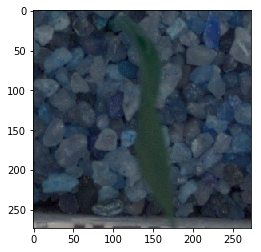

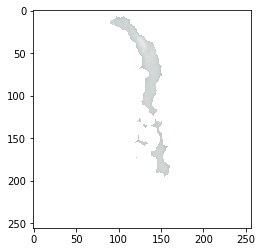

In [18]:
randm = np.random.randint(0,len(test))

img = cv2.imread(test['file'][randm])
plt.imshow(img)
plt.show()

img_processed = x_test[randm]
plt.imshow(img_processed)
plt.show()

Submit Test results (Deep Neural Network with New Model)

In [42]:
# sample_submission = pd.read_csv("sample_submission.csv",header=None) #, header=None, delim_whitespace=True
Pred_labels = np.argmax(model_new.predict(x_test),axis = 1)
Pred_labels = pd.DataFrame(Pred_labels,index =None,columns=['species_num'])
print(Pred_labels.head(5))

test_id = []
for file in os.listdir(test_dir):
    test_id.append(['{}'.format(file)])    

test_id = pd.DataFrame(test_id, columns=['file'])

test_df = pd.DataFrame()
# test_df['species_num'] = Pred_labels['species_num']
test_df['file'] = test_id['file']
test_df['species'] = [SPECIES[i] for i in Pred_labels['species_num']]
test_df.to_csv("sample_submission.csv", index=False, header=True)


   species_num
0           10
1            5
2           11
3            3
4           11


Applying Suppot Vector Machine
Extracting Features from last Layer  

Applying Suppot Vector Machine

In [43]:
model_feat = Model(inputs=model_new.input,outputs=model_new.get_layer('dense_1').output)

feat_train = model_feat.predict(x_train)
print(feat_train.shape)

feat_val = model_feat.predict(x_val)
print(feat_val.shape)

feat_test = model_feat.predict(x_test)
print(feat_test.shape)

(4275, 512)
(475, 512)
(794, 512)


Applying SVM

In [44]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')

svm.fit(feat_train,np.argmax(y_train,axis=1))

print('fitting done !!!')

fitting done !!!


Prediction Score [Training Features]

In [45]:
svm.score(feat_train,np.argmax(y_train,axis=1))

0.9883040935672515

In [46]:
Pred_labels = svm.predict(feat_test)

In [47]:
Pred_labels = pd.DataFrame(Pred_labels,index =None,columns=['species_num'])
test_df = pd.DataFrame()
# test_df['species_num'] = Pred_labels['species_num']
test_df['file'] = test_id['file']
test_df['species'] = [SPECIES[i] for i in Pred_labels['species_num']]
test_df.to_csv("sample_submission.csv", index=False, header=True)

Applying XGBOOST

In [49]:
import xgboost as xgb

xb = xgb.XGBClassifier()

xb.fit(feat_train,np.argmax(y_train,axis=1))

print('fitting done !!!')

fitting done !!!


In [50]:
xb.score(feat_train,np.argmax(y_train,axis=1))

0.99953216374269

Prediction Score [Validation Features]

In [51]:
xb.score(feat_val,np.argmax(y_val,axis=1))

0.9431578947368421

In [52]:
Pred_labels = xb.predict(feat_test)

In [54]:
Pred_labels = pd.DataFrame(Pred_labels,index =None,columns=['species_num'])
test_df = pd.DataFrame()
# test_df['species_num'] = Pred_labels['species_num']
test_df['file'] = test_id['file']
test_df['species'] = [SPECIES[i] for i in Pred_labels['species_num']]
test_df.to_csv("sample_submission.csv", index=False, header=True)